In [ ]:
# Install necessary libraries
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark==3.3.1
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 15.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845493 sha256=17551f7fed55f5d2d0281b01fc04fc29ae230d2ecfb63a10b541cefb7b4754b1
  Stored in directory: /root/.cache/pip/wheels/f8/b2/6a/477d856abe8174d27566a3c99972c3c8c03252407675cc7021
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.4
    Uninstalling pyspark-3.5.4:
      Successfully uninstalled pyspark-3.5.4


In [ ]:
# Import necessary libraries
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from google.colab import files
import pandas as pd

In [ ]:
# Create Spark session
spark = SparkSession.builder \
    .appName("Stock Price Prediction") \
    .getOrCreate()

In [ ]:
# Upload the CSV dataset
uploaded = files.upload()


Saving NFLX.csv to NFLX.csv


In [ ]:
# Load the dataset into a Spark DataFrame
file_name = list(uploaded.keys())[0]
df = spark.read.csv(file_name, header=True, inferSchema=True)

# Cast the relevant columns to numeric types
for column in ['Open', 'High', 'Low', 'Volume']:
    df = df.withColumn(column, df[column].cast("float")) # Cast to float


# Show the first few rows of the dataset
df.show()


+-------------------+------+------+------+----------+----------+---------+
|               Date|  Open|  High|   Low|     Close| Adj Close|   Volume|
+-------------------+------+------+------+----------+----------+---------+
|2018-02-05 00:00:00| 262.0| 267.9|250.03|254.259995|254.259995|1.18961E7|
|2018-02-06 00:00:00| 247.7| 266.7| 245.0|265.720001|265.720001|1.25958E7|
|2018-02-07 00:00:00|266.58|272.45|264.33|264.559998|264.559998|8981500.0|
|2018-02-08 00:00:00|267.08|267.62| 250.0|250.100006|250.100006|9306700.0|
|2018-02-09 00:00:00|253.85| 255.8|236.11|249.470001|249.470001|1.69069E7|
|2018-02-12 00:00:00|252.14|259.15| 249.0|257.950012|257.950012|8534900.0|
|2018-02-13 00:00:00|257.29|261.41| 254.7|258.269989|258.269989|6855200.0|
|2018-02-14 00:00:00|260.47|269.88|260.33|     266.0|     266.0| 1.0972E7|
|2018-02-15 00:00:00|270.03| 280.5|267.63|280.269989|280.269989|1.07597E7|
|2018-02-16 00:00:00|278.73|281.96|275.69|278.519989|278.519989|8312400.0|
|2018-02-20 00:00:00|277.

In [ ]:
df = df.dropna()

# Feature selection
features = ['Open', 'High', 'Low', 'Volume']
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [ ]:
# Transform the DataFrame to include the features
df = assembler.transform(df)

In [ ]:
import time

# Start time for MapReduce Model
start_time = time.time()

In [ ]:
# Split the dataset into training and testing sets (80% train, 20% test)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=1)


In [ ]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col

# Convert 'Close' column to DoubleType
train_df = train_df.withColumn("Close", col("Close").cast(DoubleType()))
test_df = test_df.withColumn("Close", col("Close").cast(DoubleType()))


In [ ]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='Close', numTrees=100, seed=1)


In [ ]:
# Train the model
rf_model = rf.fit(train_df)


In [ ]:
# Make predictions on the test set
predictions = rf_model.transform(test_df)

In [ ]:
# Show predictions
predictions.select("features", "Close", "prediction").show()


+--------------------+----------+------------------+
|            features|     Close|        prediction|
+--------------------+----------+------------------+
|[253.850006103515...|249.470001|261.05964239529476|
|[281.0,286.0,277....|285.929993|280.25049909425377|
|[288.75,295.64999...|294.160004| 290.4331856739347|
|[294.769989013671...|290.609985|290.63238210691435|
|[292.75,295.25,28...|290.390015| 290.3277246205817|
|[315.799987792968...|313.480011| 313.6225356545512|
|[313.070007324218...|306.700012| 313.2735556382843|
|[307.410003662109...|300.940002|303.46782602264955|
|[289.100006103515...|288.850006| 290.3199773141249|
|[297.679992675781...|298.070007| 296.3038657334709|
|[332.880004882812...|332.700012|330.02246909822475|
|[319.220001220703...|307.019989| 316.1371121558515|
|[311.070007324218...|312.459991| 316.1085108655563|
|[328.790008544921...|330.299988| 328.8817356148204|
|[334.049987792968...|331.619995|334.06112439788456|
|[329.040008544921...|344.720001| 338.09948818

In [ ]:
# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared
r2_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R-squared (R²): {r2}")

# Calculate Mean Absolute Error (MAE)
mae_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="mae")
mae = mae_evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="mse")
mse = mse_evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

#

Root Mean Squared Error (RMSE): 7.475410153164511
R-squared (R²): 0.9950914822550354
Mean Absolute Error (MAE): 5.1796096513457
Mean Squared Error (MSE): 55.88175695803507


In [ ]:
end_time = time.time()

# Calculate execution time for MapReduce
apache_time = end_time - start_time
print(f"Apache Spark Model Execution Time: {apache_time:.4f} seconds")


Apache Spark Model Execution Time: 7.1802 seconds


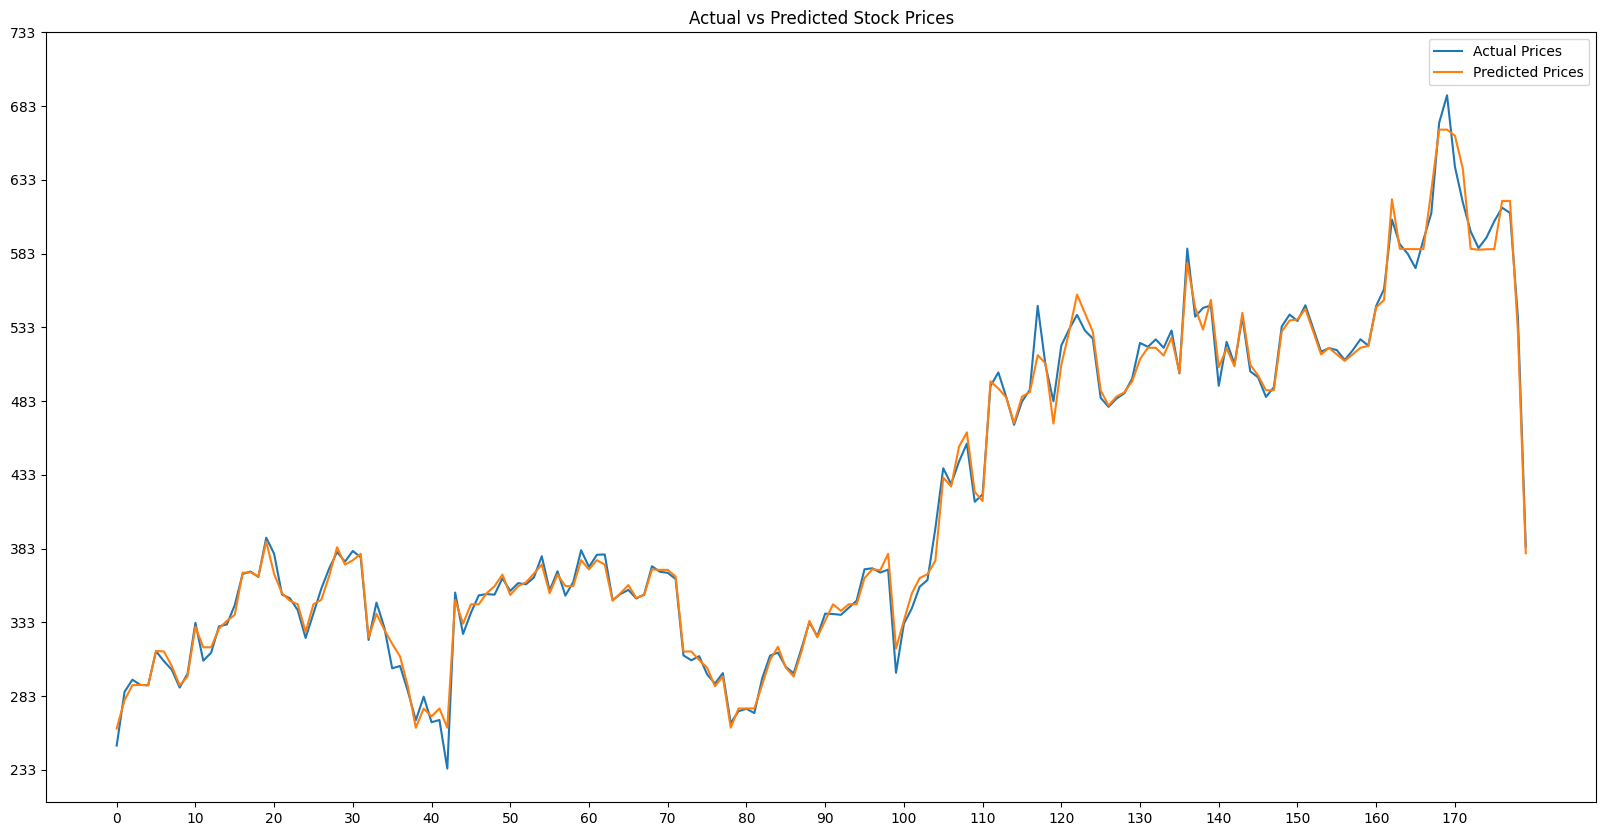

In [ ]:
from os import close
import matplotlib.pyplot as plt
import pandas as pd # Import pandas

# Convert to Pandas DataFrames and plot BEFORE stopping the Spark session
test_df_pd = test_df.select("Close").toPandas()  # Select 'Close' for actual prices
predictions_pd = predictions.select("prediction").toPandas() # Select 'prediction'

plt.figure(figsize=(20,10))
plt.plot(test_df_pd['Close'], label='Actual Prices')
plt.plot(predictions_pd['prediction'], label='Predicted Prices')
plt.legend()
plt.title('Actual vs Predicted Stock Prices')

# Set Y-axis ticks with increments of 50
plt.xticks(range(0, len(test_df_pd), 10))
# Get min/max from 'Close' column values, not the DataFrame itself
plt.yticks(range(int(min(test_df_pd['Close'])), int(max(test_df_pd['Close'])) + 50, 50))
plt.show()

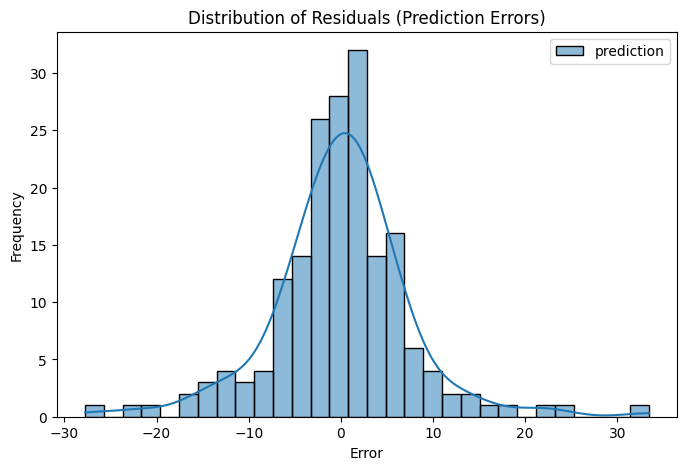

In [ ]:
import seaborn as sns

# Example: Residuals Distribution
residuals = test_df_pd.values - predictions_pd
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title('Distribution of Residuals (Prediction Errors)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Stop the Spark session
spark.stop()